In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colormaps as cm
from sklearn.decomposition import PCA

In [2]:
# read weights from file weights.npy
Wxh_weights = np.load('../data/Wxh_contextual.npy') # (400, 50, 4, 64)
Whh_weights = np.load('../data/Whh_contextual.npy') # (400, 50, 64, 64)
Wha_weights = np.load('../data/Wha_contextual.npy') # (400, 50, 64, 2)
Whc_weights = np.load('../data/Whc_contextual.npy') # (400, 50, 64, 1)
history = np.load('../data/history_contextual.npy') # (20000, 3)
activity = np.load('../data/activity_contextual.npy') # (400, 50, 64)

# n_epochs, n_times, n_weights = weights.shape

In [3]:
# extract training data first 190 epochs x 2 contexts x 50 trials:
Wxh_weights_train = Wxh_weights[:-20,:,:,:]
Whh_weights_train = Whh_weights[:-20,:,:,:]
Wha_weights_train = Wha_weights[:-20,:,:,:]
Whc_weights_train = Whc_weights[:-20,:,:,:]
history_train = history[:-2000,:]
activity_train = activity[:-40,:,:]

# extract testing data final 10 epochs x 2 contexts x 50 trials:
Wxh_weights_test = Wxh_weights[-20:,:,:,:]
Whh_weights_test = Whh_weights[-20:,:,:,:]
Wha_weights_test = Wha_weights[-20:,:,:,:]
Whc_weights_test = Whc_weights[-20:,:,:,:]
history_test = history[-2000:,:]
activity_test = activity[-40:,:,:]


In [4]:
# get actions (2nd dim in history)
actions_train = history_train[:,1]
actions_test = history_test[:,1]

In [5]:
activity_train.shape[0]*activity_train.shape[1]

18000

In [6]:
# append activity data to be 18000 x 64
activity_train_new = np.zeros((18000,64))
c=0
for i in range(activity_train.shape[0]):
    for j in range(activity_train.shape[1]):
        activity_train_new[c,:] = activity_train[i,j,:]
        c += 1
print(c)

activity_test_new = np.zeros((2000,64))
c = 0
for i in range(activity_test.shape[0]):
    for j in range(activity_test.shape[1]):
        activity_test_new[c,:] = activity_test[i,j,:]
        c += 1
print(c)

18000
2000


In [18]:
Whh_mean

array([[-0.18849985,  0.22770022,  0.19199659, ...,  0.13613988,
        -0.12935987,  0.05090592],
       [ 0.02008514,  0.3212211 , -0.04986658, ..., -0.04848184,
         0.31242728,  0.14402044],
       [-0.20154287,  0.18144089,  0.18866731, ..., -0.18135072,
        -0.05526432,  0.20279321],
       ...,
       [ 0.01003627, -0.0101695 ,  0.12554678, ...,  0.02837168,
        -0.13883649, -0.19234246],
       [ 0.09889302, -0.07651995, -0.2699156 , ...,  0.18888369,
        -0.17829505,  0.10271201],
       [ 0.18854196, -0.0286667 , -0.1307392 , ..., -0.19300872,
         0.0374088 , -0.1357025 ]], dtype=float32)

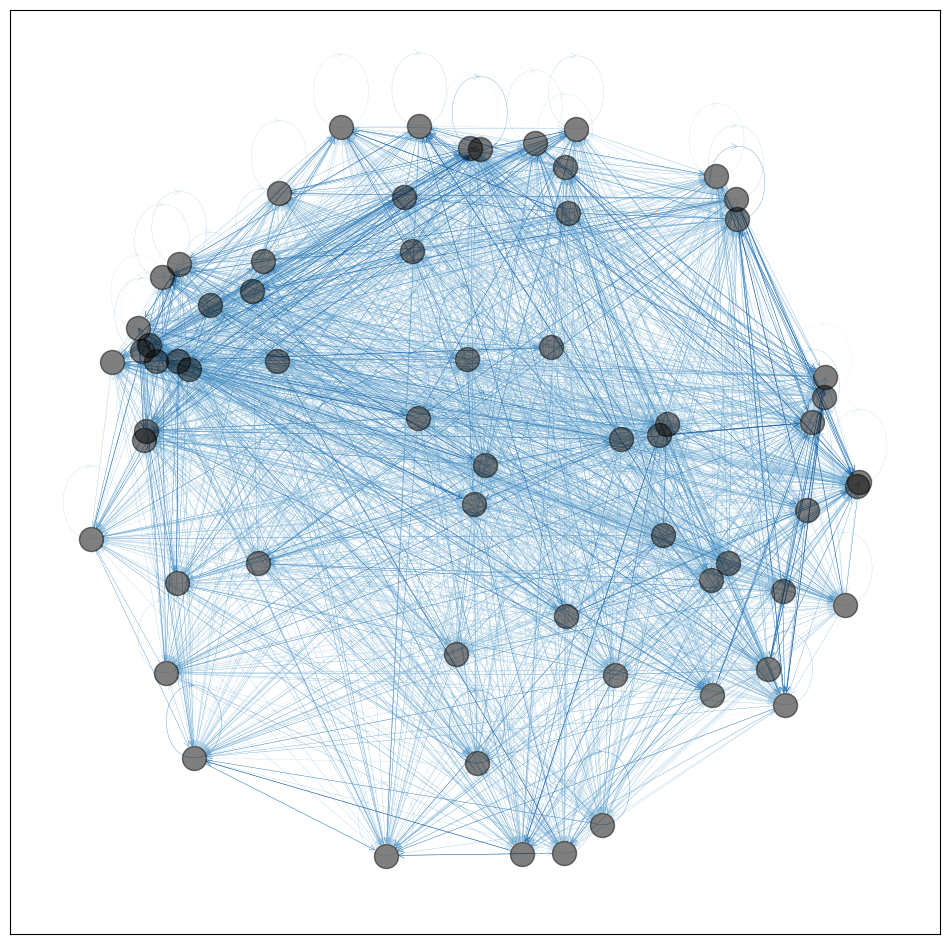

In [28]:
Whh_mean = np.mean(np.mean(Whh_weights_test, axis=0), axis=0)

import networkx as nx

# Create a directed graph from the matrix
G = nx.from_numpy_array(Whh_mean, create_using=nx.DiGraph)

# Set up the plot
plt.figure(figsize=(12, 12))

# Draw the graph
pos = nx.spring_layout(G)  # Positions for all nodes
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]

nx.draw_networkx_nodes(G, pos, node_size=300, node_color='black', alpha=0.5)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, edge_color=weights, edge_cmap=plt.cm.Blues, arrowstyle='->', arrowsize=10)
# nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif")

# Display the plot
plt.title("")
# plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), label="Edge Weight")
plt.show()

In [99]:
# Step 2: Run PCA using sklearn
pca = PCA(n_components=2)
pca_result = pca.fit_transform(activity_train_new).T

In [100]:
pca_result.shape

(2, 18000)

In [101]:
def create_pca_trajectories_animation(actions, history, filename='pca_trajectories.mp4', fps=10):
    # Step 1: Fit PCA to the history data
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(history).T

    # Step 2: Setup the plot for animation
    fig, ax = plt.subplots()
    line, = ax.plot([], [], '-')
    marker, = ax.plot([], [], 'o')

    line.set_alpha(0.5)
    line.set_color('black')

    marker.set_alpha(0.5)

    # Set up the plot limits
    ax.set_xlim(np.min(pca_result[0]) - 1, np.max(pca_result[0]) + 1)
    ax.set_ylim(np.min(pca_result[1]) - 1, np.max(pca_result[1]) + 1)
    ax.set_title('PCA Trajectories Over Time')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

    colors = []
    markers = []

    # Step 3: Initialize the plot
    def init():
        line.set_data([], [])
        marker.set_data([], [])
        return line,

    # Step 4: Update the plot for each frame
    def update(frame):
        line.set_data(pca_result[0][:frame+1], pca_result[1][:frame+1])

        # Determine the color based on the action at this frame
        if actions[frame] == 0:  # red
            current_color = 'red'
        elif actions[frame] == 1:  # blue
            current_color = 'blue'
        else:
            current_color = 'black'  # default to black or any other color if not 0 or 1

        # Append the current color to the list of colors
        colors.append(current_color)
        
        # Set the marker color for the current point
        marker, = ax.plot(pca_result[0][frame], pca_result[1][frame], 'o', color=current_color, alpha=0.5)
        markers.append(marker)
        
        return line, *markers

    # Step 5: Create the animation
    ani = animation.FuncAnimation(fig, update, frames=2000, init_func=init, blit=True, repeat=False)

    # Step 6: Save the animation as a video file
    ani.save(filename, writer='ffmpeg', fps=fps)

    # Show the animation
    plt.show()

In [102]:
actions_train.shape

(18000,)

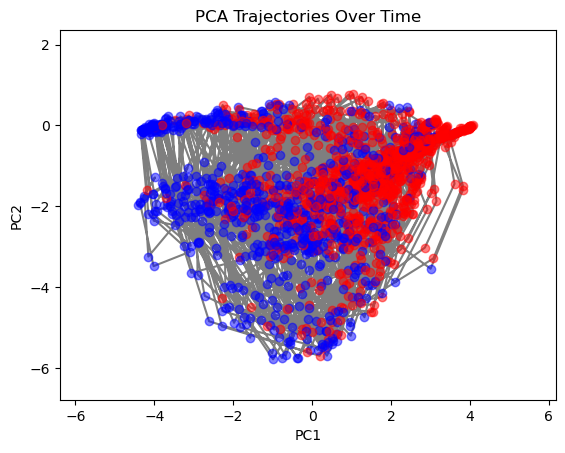

In [103]:
create_pca_trajectories_animation(actions_train, activity_train_new, filename='pca_trajectories_train.mp4')

KeyboardInterrupt: 

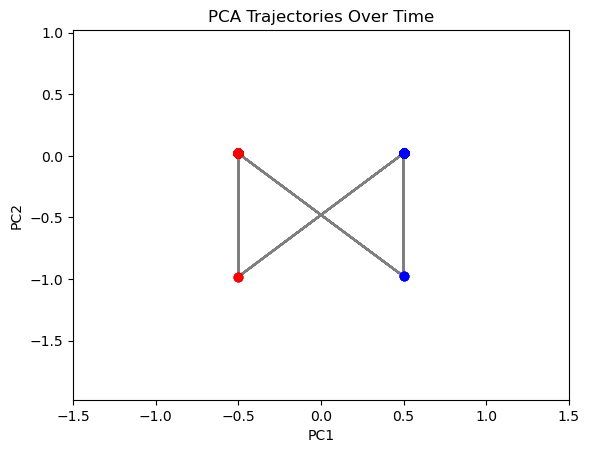

In [104]:
create_pca_trajectories_animation(actions_test, history_test, filename='pca_trajectories_test.mp4')

<hr>

In [107]:
activity_test.shape

(40, 50, 64)

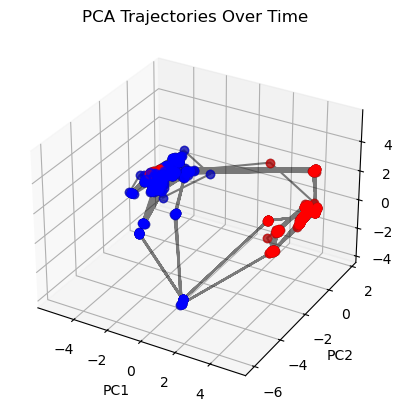

In [108]:
# Step 2: Run PCA using sklearn with 3 components
pca3 = PCA(n_components=3)
pca_result3 = pca3.fit_transform(activity_test_new).T

# Step 3: Plot and create an animation of the PCA trajectories over time in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
line, = ax.plot([], [], [], 'o-')

# Set up the plot limits
ax.set_xlim(np.min(pca_result3[0]) - 1, np.max(pca_result3[0]) + 1)
ax.set_ylim(np.min(pca_result3[1]) - 1, np.max(pca_result3[1]) + 1)
ax.set_zlim(np.min(pca_result3[2]) - 1, np.max(pca_result3[2]) + 1)
ax.set_title('PCA Trajectories Over Time')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

markers = []
def init():
    marker.set_data([], [])
    line.set_data([], [])
    line.set_alpha(0.5)
    line.set_color('black')
    line.set_3d_properties([])
    return line, marker

def update(frame):
    line.set_data(pca_result3[0][:frame+1], pca_result3[1][:frame+1])
    line.set_3d_properties(pca_result3[2][:frame+1])
    
    # Determine the color based on the action at this frame
    if actions_test[frame] == 0:  # red
        current_color = 'red'
    elif actions_test[frame] == 1:  # blue
        current_color = 'blue'
    else:
        current_color = 'black'  # default to black or any other color if not 0 or 1

    # Plot the marker for the current frame
    marker, = ax.plot([pca_result3[0][frame]], [pca_result3[1][frame]], [pca_result3[2][frame]], 'o', color=current_color, alpha=.5)
    markers.append(marker)
    
    return line, *markers

ani3 = animation.FuncAnimation(fig, update, frames=2000, init_func=init, blit=True, repeat=False)

# To save the animation as a video file (e.g., MP4), uncomment the following lines
ani3.save('pca_trajectories_test_3d.mp4', writer='ffmpeg', fps=10)

# Show the animation
plt.show()